# Diabimmune analysis

The notebook does pre-processing of Diabimmune DeepFRI, EggNOG annotations and visualization

Inputs:

- PATHS: list of paths to the datasets

Plots:

- DeepFRI-eggNOG-area plots
- Venn diagram for different sets of genes
- Annotation coverage plots

### Imports

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import re
import obonet
import networkx as nx
import gc
gc.enable()
from matplotlib_venn import venn2
from matplotlib_venn import venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn3_unweighted
pd.options.mode.chained_assignment = None

#### Data paths

In [2]:
DEEPFRI_PATH = "/storage/mmaranga/"
DEEPFRI_FILE = DEEPFRI_PATH+"merged_deepfri_output_260521.tsv"
KMA_PATH = "/storage/mmaranga/diabimmune-infant_metagenomes/kma"
GO_PATH = "/home/MCB/mmaranga/"
GO_TREE = GO_PATH+"go-basic.obo.1"
GO_INFORMATIVE_PATH = "/home/MCB/mmaranga/"
GO_INFORMATIVE_FILE = GO_INFORMATIVE_PATH+"GO_informative.txt"
MAPPING_TABLE_PATH = "/storage/mmaranga/"
MAPPING_TABLE = MAPPING_TABLE_PATH+"gene_mapping.tsv"

#### Data preparation
#### Load and pre process data

#### Loading all normalized KMA relative abundance files for all samples

In [3]:
def load_kma_file(path):
    """
    Reads KMA output 
    Parameters
    ----------
    input_file : tsv
        tsv file kma output
    Returns
    -------
    Pandas dataframe
    """
    all_files = glob.glob(KMA_PATH + "/*.txt")
    kma_cpm = []
    for filename in all_files:
        kma_df = pd.read_csv(filename, sep="\t" )
        kma_df["Sample"] = os.path.basename(filename).replace(".geneCPM.txt", "")
        kma_cpm.append(kma_df)
    kma_cpm_df = pd.concat(kma_cpm, axis=0, ignore_index=True)
    # rename Gene_ID column
    kma_cpm_df.rename(columns={'Gene ID':'Gene_ID'}, inplace=True)
    return kma_cpm_df

In [4]:
kma_df = load_kma_file(KMA_PATH)

#### load gene mapper table

In [5]:
# loads mapper table
mapped_genes = pd.read_csv(MAPPING_TABLE , sep="\t", usecols = ["Cluster ID", "Gene ID", "GOs", "eggNOG free text desc."], low_memory=False)


#### Load deepfri annotation file and  pre-process the data

In [3]:
# load deepfri file
def deepfri_annotation_file(deepfri_file):
    """
    Reads deepfri function annotation file
    """
    deepfri_df = pd.read_csv(deepfri_file , sep=",", header=None, names=['id', 'goterm', 'model', 'score', 'name'])
    deepfri_df = deepfri_df.astype({'score': 'float32'})
    return deepfri_df

In [4]:
# create deepfri function dataframe and select cnn molecular functions with threshold of 0.2
deepfri_df = deepfri_annotation_file(DEEPFRI_FILE)
cnn_mf = deepfri_df.loc[(deepfri_df['model'] == 'cnn_mf') & (deepfri_df['score'] >= 0.2)]

#### Load informative GO terms sets

In [6]:
# informative Gene ontology sets
def GO_informative_file(GO_file):
    """
    Reads 614 informative sets of GO terms
    A comprehensive representation of GO term sets that have more specific ancestors in the GO hierarchy
    """
    ontology_df = pd.read_csv(GO_file, sep='\t', header=None)
    # preprocess informative GO dataframe
    ontology_df = ontology_df[0].str.split("|", n = 4, expand = True).rename(columns={0:'Goterm',1:'ont',2:'Score',3:'fxn_Name'})
    return ontology_df

In [7]:
GO_informative_df = GO_informative_file(GO_INFORMATIVE_FILE)

#### Load EggNOG predictions from the mapper table
#### Perform Gene ontology propagation

In [12]:
# select gene ID, GO column and drop NANs 
genes_GO_df = mapped_genes[["Gene ID", "GOs"]].dropna()


#### Propagation of GO terms
#### Uses new GO obo tree 
#### The GO obo tree is obtained from http://geneontology.org/docs/download-ontology/#go_obo_and_owl

In [13]:
# load the GO tree
with open(GO_TREE  , 'r') as go_graph_fh:
    go_graph = obonet.read_obo(go_graph_fh)

In [14]:
# perform propagation of GO terms
def propagate_go(goterms: list):
    all_goterms = set()
    for goterm in list(goterms):
#         print('GO:%s' % goterm)
        # dealing with obsolete GO terms
        try:
            parents = nx.descendants(go_graph, goterm)
#             print(parents)
            all_goterms = all_goterms.union(parents)
#             print('try all GOs:%s' % all_goterms)
        except:
#             print("I am in an exception")
            all_goterms = all_goterms.union(set([goterm]))       
#             print('except all GOs:%s' % all_goterms)
    # adding original GOs to `all_goterms`
    all_goterms = all_goterms.union(set(goterms))
    # pruning root terms
    all_goterms = all_goterms.difference(root_terms)
#     print('final all GOs:%s' % all_goterms)
    # return `all_goterms` as a comma-separated string
    ','.join(sorted(all_goterms))
    return sorted(all_goterms)

In [15]:
# propagate GO terms

root_terms = set(['GO:0008150', 'GO:0003674', 'GO:0005575'])

# update the gene GO list
genes_GO_df['GOs_propagated'] = genes_GO_df['GOs'].apply(lambda x: propagate_go(x.split(','))).apply(lambda x: ','.join(map(str, x)))


#### Comparing original GO and propagated GO

In [17]:
orig = []
prop = []
for i, row in genes_GO_df.iterrows():
    orig.append(len(row['GOs'].split(','))) 
    prop.append(len(row['GOs_propagated'].split(',')))

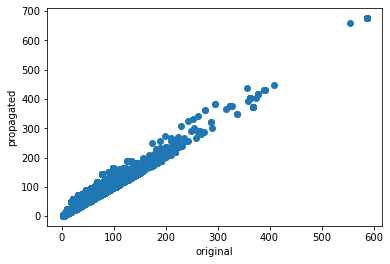

In [20]:
# scatter plot for original and propagated GOs
plt.scatter(orig,prop)
plt.xlabel("original")
plt.ylabel("propagated")
plt.savefig("original_vs_propagated_GOs")

### Comparisons between EggNOG and DeepFRI predictions

#### Visualization
#### Proportion of genes annnotated with eggNOG

In [17]:
# transform the dataframe
GO_propagated_df = genes_GO_df.set_index('Gene ID')\
          .GOs_propagated.str.split(',', expand=True)\
          .stack()\
          .reset_index('Gene ID')\
          .rename(columns={0:'GOs_propagated'})\
          .reset_index(drop=True)

In [18]:
# Filter out generic GO terms
# map Propagated GO to informative GO df
GO_propagated_informative = pd.merge(GO_propagated_df, GO_informative_df, 
        left_on='GOs_propagated', right_on='Goterm',
        how='inner')

In [32]:
# select MF functions
GO_propagated_informative_mf = GO_propagated_informative[GO_propagated_informative['ont'] == 'MF']

# add sample column
GO_propagated_informative_mf['Sample'] = GO_propagated_informative_mf['Gene ID'].apply(lambda x: x.split("_k")[0])

###  Aggregate gene quantifications into quantifications of gene functions

In [ ]:
# map to KMA dataframe
GO_propagated_kma_df = pd.merge(GO_propagated_informative_mf, kma_df, 
        left_on='Gene ID', right_on='Gene_ID',
        how='outer', suffixes=("_eggNOG", "_kma"))

### Normalize the relative abundances
#### Data preparation

In [24]:
def prepare_eggNOG_data(data):
    data.loc[data['Gene ID'].isna(), 'CPM'] = 0 # replace CPM with zero where Gene ID is NAN
    data['CPM'] = data['CPM'].fillna(0)  # replace NaN with 0
    return data

In [25]:
# load data 
GO_propagated_kma_df = prepare_eggNOG_data(GO_propagated_kma_df)

In [26]:
# Normalization
GO_propagated_grouped_samples = GO_propagated_kma_df.groupby('Sample_kma').sum()['CPM']/1000000
GO_propagated_grouped_samples.sort_values( inplace=True)

In [28]:
def stacked_bar_plt(grouped_eggNOG_data):
    bottom = 0 # bars shall be gradually incremental 
    # Annotated
    plt.bar(range(len(grouped_eggNOG_data)), grouped_eggNOG_data, bottom=bottom, width=1, color='steelblue')
    # Unannotated
    bottom  += grouped_eggNOG_data
    plt.bar(range(len(grouped_eggNOG_data)), 1 - grouped_eggNOG_data, bottom=bottom, width=1, color='skyblue')
    plt.xlabel("Samples")
    plt.ylabel("Relative abundance")
    plt.text(600,0.1,'annotated',horizontalalignment='right')
    plt.text(600,0.8,'unannotated',horizontalalignment='right')

#### EggNOG area bar Plot

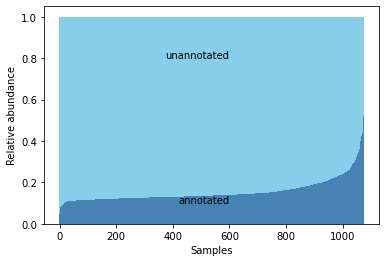

In [29]:
stacked_bar_plt(GO_propagated_grouped_samples)

### Area plot of proportion of genes annotated by deepFRI

#### Filter GO terms only to include informative sets

In [52]:
deepfri_informative_cnn_mf = pd.merge(cnn_mf, GO_informative_df, 
        left_on='goterm', right_on='Goterm',
        how='inner')

In [ ]:
# map GO_informative_cnn_mf to KMA relative abundance df
deepfri_GO_cpm = pd.merge(deepfri_informative_cnn_mf.drop(columns='name'), kma_df, 
        left_on='id', right_on='Gene_ID',
        how='outer' , suffixes=("_cnn", "_kma")).drop(columns='Gene_ID')

### Normalization

In [ ]:
def prepare_data(data):
    deepfri_GO_cpm.loc[deepfri_GO_cpm['id'].isna(), 'CPM'] = 0  # replace CPMs with zero where gene id has NaN
    deepfri_GO_cpm['CPM'] = deepfri_GO_cpm['CPM'].fillna(0)  # replace NANs in CPM column with zero
    return data

In [ ]:
# process deepfri_GO_cpm
deepfri_GO_df = prepare_data(deepfri_GO_cpm)

In [ ]:
# normalize CPMs
GO_grouped_samples = deepfri_GO_df.groupby('Sample_kma').sum()['CPM']/1000000 # group by samples and divide CPMs by a million
GO_grouped_samples.sort_values( inplace=True)

In [ ]:
def bar_plt(grouped_data):
    bottom = 0
    # Annotated
    plt.bar(range(len(grouped_data)),grouped_data, bottom=bottom, width=1)
    # Unannotated
    bottom  += grouped_data
    plt.bar(range(len(grouped_data)), 1 - grouped_data, bottom=bottom, width=1,color='skyblue')
    plt.xlabel("Samples")
    plt.ylabel("Relative abundance")
    #plt.yscale('log')
    #plt.ylim([0.9,1])
    plt.text(600,0.1,'annotated',horizontalalignment='right')
    plt.text(600,0.9,'unannotated',horizontalalignment='right')
    

In [ ]:
bar_plt(GO_grouped_samples)

### Compare gene sets annotated by DeepFRI and EggNOG

In [24]:
# EggNOG_mf go terms obtained from eggnogdb.embl.de/download/eggnog_4.5/all_OG_annotations.tsv.gz
eggnog_mf_go = pd.read_csv('eggnog_mf_go', sep='\t')
eggnog_mf_go = eggnog_mf_go.drop_duplicates('goterm')

In [34]:
# Select only MF GO terms
eggnog_mf_GO_propagated_df = pd.merge(GO_propagated_df, eggnog_mf_go,
        left_on='GOs_propagated', right_on='goterm', how='inner')

In [53]:
# convert to a list
deepfri_genes= cnn_mf.drop_duplicates('id')
deepfri_genes = deepfri_genes['id'].tolist()

# EggNOG
eggnog_genes = eggnog_mf_GO_propagated_df.drop_duplicates('Gene ID')
eggnog_genes = eggnog_genes['Gene ID'].tolist()


In [40]:
# genes unique to one method
items_only_in_cnn_mf_unique = set(deepfri_genes).difference(set(eggnog_genes))
items_only_in_eggNOG = set(eggnog_genes).difference(set(deepfri_genes))

# intersection
deep_egg_intersect = set(deepfri_genes).intersection(set(eggnog_genes))

#### Venn diagrams

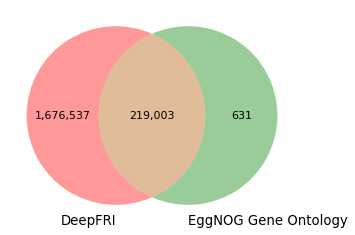

In [110]:
plt.rcParams.update({'font.size': 11})
b = venn2_unweighted(subsets = (len(items_only_in_cnn_mf_unique), len(items_only_in_eggNOG), len(deep_egg_intersect)),
          set_labels=('DeepFRI', 'EggNOG Gene Ontology'))
b.get_label_by_id('10').set_text('1,676,537')
b.get_label_by_id('11').set_text('219,003')
b.get_label_by_id('01').set_text('631')
plt.savefig('deepfri_eggnog_mf_venn_April2022.png',dpi=300)


### Subset of genes annotated by informative GO terms

In [47]:
# select MF functions
GO_propagated_informative_mf = GO_propagated_informative[GO_propagated_informative['ont'] == 'MF']

In [55]:
# convert to a list
deepfri_inf_genes= deepfri_informative_cnn_mf.drop_duplicates('id')
deepfri_inf_genes = deepfri_inf_genes['id'].tolist()

# EggNOG
eggnog_inf_genes = GO_propagated_informative_mf.drop_duplicates('Gene ID')
eggnog_inf_genes = eggnog_inf_genes['Gene ID'].tolist()


In [56]:
# genes unique to one method
items_only_in_cnn_mf_inf = set(deepfri_inf_genes).difference(set(eggnog_inf_genes))
items_only_in_eggNOG_inf = set(eggnog_inf_genes).difference(set(deepfri_inf_genes))

# intersection
deep_egg_inf_intersect = set(deepfri_inf_genes).intersection(set(eggnog_inf_genes))

#### Venn diagram

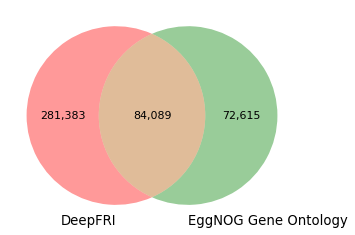

In [111]:
c = venn2_unweighted(subsets = (len(items_only_in_cnn_mf_inf), len(items_only_in_eggNOG_inf), len(deep_egg_inf_intersect)),
          set_labels=('DeepFRI', 'EggNOG Gene Ontology'))
c.get_label_by_id('10').set_text('281,383')
c.get_label_by_id('11').set_text('84,089')
c.get_label_by_id('01').set_text('72,615')
plt.savefig('deepfri_eggnog_mf_informative_venn_April2022.png',dpi=200)


#### 3 way venn diagrams
#### Using EggNOG free text description

In [79]:
EggNOG_free_text = mapped_genes[['Gene ID', 'eggNOG free text desc.']]
EggNOG_free_text = EggNOG_free_text.dropna()

In [80]:
# covert to a list
# DeepFRI
deepfri_mf_genes = cnn_mf.drop_duplicates('id')
deepfri_mf_genes = deepfri_mf_genes['id'].tolist()

#EggNOG
eggnog_all_genes = GO_propagated_df.drop_duplicates('Gene ID')
eggnog_all_genes = eggnog_all_genes['Gene ID'].tolist()

#EggNOG free text
eggnog_text_genes = EggNOG_free_text.drop_duplicates('Gene ID')
eggnog_text_genes = eggnog_text_genes['Gene ID'].tolist()

In [91]:
eggnog_text_genes_set = set(eggnog_text_genes)
deepfri_genes_set = set(deepfri_mf_genes)
eggnog_genes_set = set(eggnog_all_genes)
eggnog_mf_set = set(eggnog_genes)

#### Visualization

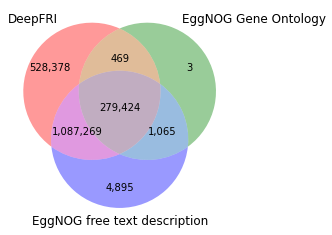

In [113]:
plt.rcParams.update({'font.size': 10})
d = venn3_unweighted([deepfri_genes_set, eggnog_genes_set, eggnog_text_genes_set],
                     ('DeepFRI', 'EggNOG Gene Ontology', 'EggNOG free text description'))
d.get_label_by_id('10').set_text('528,378')
d.get_label_by_id('011').set_text('1,065')
d.get_label_by_id('111').set_text('279,424')
d.get_label_by_id('101').set_text('1,087,269')
d.get_label_by_id('001').set_text('4,895')
plt.savefig('keyword_eggnog_allgo_deepfri_April2022.png',dpi=200)

#### EggNOG only MF GO terms

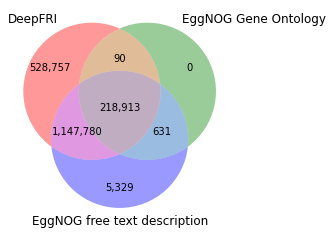

In [114]:
a = venn3_unweighted([deepfri_genes_set, eggnog_mf_set, eggnog_text_genes_set],
                     ('DeepFRI', 'EggNOG Gene Ontology', 'EggNOG free text description'))
a.get_label_by_id('10').set_text('528,757')
a.get_label_by_id('111').set_text('218,913')
a.get_label_by_id('101').set_text('1,147,780')
a.get_label_by_id('001').set_text('5,329')
plt.savefig('keyword_eggnog_mf_deepfri_April2022.png',dpi=200)

### Proportion of metagenomic gene abundance with functional annotation

In [21]:
eggnog_cpm  = GO_propagated_grouped_samples.reset_index()
eggnog_cpm['annotation']='EggNOG Gene Ontology'

In [12]:
deepfri_cpm = GO_grouped_samples.reset_index()
deepfri_cpm['annotation']='DeepFRI'

In [22]:
# compute the proportions for eggnog
eggnog_cpm["CPM"] = pd.to_numeric(eggnog_cpm["CPM"], downcast="float")
eggnog_cpm["perc_CPM"] = eggnog_cpm["CPM"] *100
eggnog_cpm = eggnog_cpm[["perc_CPM", "annotation"]]

In [24]:
deepfri_cpm["DeepFRI_CPM"] = pd.to_numeric(deepfri_cpm["CPM"], downcast="float")
deepfri_cpm["perc_CPM"] = deepfri_cpm["CPM"] *100
deepfri_cpm = deepfri_cpm[['perc_CPM', "annotation"]]

In [25]:
# Concatenate eggnog and deepfri cpms
egg_deep_cpm = pd.concat([deepfri_cpm, eggnog_cpm])

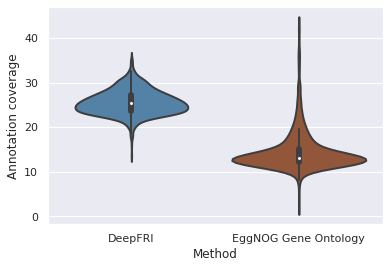

In [29]:
# violin plot
plt.rcParams.update({'font.size': 19})
sns.set(style="darkgrid")
my_pal = {"EggNOG Gene Ontology": "sienna", "DeepFRI": "steelblue"}
sns.violinplot(x='annotation', y='perc_CPM', data=egg_deep_cpm,linewidth=2,palette=my_pal)
plt.xlabel("Method")
plt.ylabel("Annotation coverage")
plt.savefig('annotation_cov_may2022.png',dpi=300)